In [ ]:
!pip install opencv-python

In [ ]:
import tensorflow as tf
print("TPU:", tf.config.list_logical_devices('TPU'))

TPU: []


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import os
import cv2
import numpy as np
import random
import psutil

def get_ram_usage():
    process = psutil.Process(os.getpid())
    mem = process.memory_info().rss / (1024 ** 3)  # GB
    print(f"Current RAM usage: {mem:.2f} GB")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install tensorflow

In [ ]:
import os
import cv2
import numpy as np
import random

# The generator
def patch_batch_generator(file_list, image_dir, density_dir,
                           input_size=(1024, 1024), patch_size=512, batch_size=8, output_size=64):
    h_img, w_img = input_size

    while True:
        image_batch = []
        density_batch = []

        while len(image_batch) < batch_size:
            # Randomly pick one image
            image_file = random.choice(file_list)

            # Load image
            image_path = os.path.join(image_dir, image_file)
            density_path = os.path.join(density_dir, image_file.replace('.jpg', '.npy'))

            image = cv2.imread(image_path)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = cv2.resize(image, (w_img, h_img))
            image_norm = image / 255.0

            # Load density map
            density = np.load(density_path)
            old_h, old_w = density.shape

            # Resize density map to match image size
            density_resized = cv2.resize(density, (w_img, h_img), interpolation=cv2.INTER_LINEAR)
            scaling_factor = (old_h * old_w) / (h_img * w_img)
            density_resized = density_resized * scaling_factor

            # Extract random patch from image and density (both 512x512)
            x_max = w_img - patch_size
            y_max = h_img - patch_size
            x = random.randint(0, x_max)
            y = random.randint(0, y_max)

            image_patch = image_norm[y:y+patch_size, x:x+patch_size, :]
            density_patch = density_resized[y:y+patch_size, x:x+patch_size]

            # Resize density patch to output size (e.g., 64x64)
            density_patch_resized = cv2.resize(density_patch, (output_size, output_size), interpolation=cv2.INTER_LINEAR)
            # Adjust density sum after resizing
            density_patch_resized *= (patch_size * patch_size) / (output_size * output_size)
            density_patch_resized = np.expand_dims(density_patch_resized, axis=-1)

            image_batch.append(image_patch)
            density_batch.append(density_patch_resized)

        yield np.array(image_batch), np.array(density_batch)

# Directory setup
image_dir= '/content/drive/MyDrive/images'
density_dir = '/content/drive/MyDrive/train_data_sigma_9/'

# Prepare file list
image_files = os.listdir(image_dir)
image_files = [f for f in image_files if f.endswith('.jpg')]

from sklearn.model_selection import train_test_split
train_files, val_files = train_test_split(image_files, test_size=0.1, random_state=42)

# Create generators with batch_size = 8 (you can change)
train_gen = patch_batch_generator(train_files, image_dir, density_dir, batch_size=8)
val_gen = patch_batch_generator(val_files, image_dir, density_dir, batch_size=8)

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, initializers
from keras.models import Model
from keras.layers import *
from tensorflow.keras.optimizers import Adam

class CBAMLayer(tf.keras.layers.Layer):
    def __init__(self, reduction_ratio=8, **kwargs):
        super(CBAMLayer, self).__init__(**kwargs)
        self.reduction_ratio = reduction_ratio

    def build(self, input_shape):
        self.channel = input_shape[-1]
        self.shared_dense_one = tf.keras.layers.Dense(self.channel // self.reduction_ratio,
                                                      activation='relu')
        self.shared_dense_two = tf.keras.layers.Dense(self.channel)

        self.conv_spatial = tf.keras.layers.Conv2D(filters=1,
                                                   kernel_size=7,
                                                   padding='same',
                                                   activation='sigmoid')

    def call(self, inputs):
        # ----- Channel Attention -----
        avg_pool = tf.reduce_mean(inputs, axis=[1, 2], keepdims=True)
        max_pool = tf.reduce_max(inputs, axis=[1, 2], keepdims=True)

        avg_out = self.shared_dense_two(self.shared_dense_one(avg_pool))
        max_out = self.shared_dense_two(self.shared_dense_one(max_pool))
        scale = tf.nn.sigmoid(avg_out + max_out)
        x = inputs * scale

        # ----- Spatial Attention -----
        avg_pool = tf.reduce_mean(x, axis=-1, keepdims=True)
        max_pool = tf.reduce_max(x, axis=-1, keepdims=True)
        concat = tf.concat([avg_pool, max_pool], axis=-1)
        scale = self.conv_spatial(concat)
        x = x * scale
        return x

Model_Input=Input(shape=(None, None,3))
from keras.applications.vgg16 import VGG16

base_model = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(None, None,3))

conv_base = Model(inputs=base_model.input, outputs=base_model.get_layer('block4_conv3').output)

conv_base.summary()

x = conv_base(Model_Input)

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, None, None, 3)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, None, None, 64) │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, None, None, 64) │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, None, None, 64) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, None, None,     │        73,856 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, None, None,     │       147,584 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, None, None,     │             0 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, None, None,     │       295,168 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, None, None,     │       590,080 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, None, None,     │       590,080 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, None, None,     │             0 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, None, None,     │     1,180,160 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,635,264 (29.13 MB)

 Trainable params: 7,635,264 (29.13 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# import tensorflow as tf
# import tensorflow_hub as hub
# from tensorflow.keras.layers import Input, Lambda
# from tensorflow.keras.models import Model

# # Load HRNet from TF Hub
# hrnet = hub.KerasLayer(
#     "https://tfhub.dev/google/HRNet/ade20k-hrnetv2-w48/1",
#     trainable=False
# )

# # Define model
# inputs = Input(shape=(512, 512, 3))  # or use a fixed shape (HRNet works better with fixed shapes)
# x = Lambda(lambda image: hrnet(image))(inputs)

# model = Model(inputs, x)
# model.summary()

In [ ]:
p1 = CBAMLayer()(x)

# Column A - Multi-scale skip connections
a1 = Conv2D(256, 3, padding='same', activation='relu')(p1)
a2 = Conv2D(256, 3, padding='same', activation='relu')(a1)
a3 = Conv2D(128, 3, padding='same', activation='relu')(a2)
a4 = Conv2D(128, 3, padding='same', activation='relu')(a3)

# Multiple skip connections at different scales
skip_early = add([a1, a2])  # Early features (256 channels)
skip_late = add([a3, a4])   # Late features (128 channels)

# Combine multi-scale features
early_reduced = Conv2D(64, 1, activation='relu')(skip_early)  # 256→64
late_reduced = Conv2D(64, 1, activation='relu')(skip_late)    # 128→64  # YOU MISSED THIS

a5 = concatenate([early_reduced, late_reduced])  # 64+64=128 channels
a6 = Conv2D(64, 3, padding='same', activation='relu')(a5)   # Final processing  # YOU MISSED THIS

# Column B - Add skip connections here too for consistency
b1 = Conv2D(256, 5, padding='same', activation='relu')(p1)
b2 = Conv2D(256, 5, padding='same', activation='relu')(b1)
b3 = Conv2D(128, 3, padding='same', activation='relu')(b2)
b4 = Conv2D(64, 3, padding='same', activation='relu')(b3)

# Final merge
merged_output = concatenate([a6, b4])  # 64+64=128 channels
k = Conv2D(64, 1, activation='relu')(merged_output)
d1 = CBAMLayer()(k)
e1 = Conv2D(1, 1)(d1)

model = Model(inputs=Model_Input, outputs=e1)
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, None,      │          0 │ -                 │
│ (InputLayer)        │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional          │ (None, None,      │  7,635,264 │ input_layer[0][0] │
│ (Functional)        │ None, 512)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cbam_layer          │ (None, None,      │     66,211 │ functional[0][0]  │
│ (CBAMLayer)         │ None, 512)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, None,      │  1,179,904 │ cbam_layer[0][0]  │
│                     │ None, 256)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, None,      │    590,080 │ conv2d_1[0][0]    │
│                     │ None, 256)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, None,      │    295,040 │ conv2d_2[0][0]    │
│                     │ None, 128)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, None,      │    147,584 │ conv2d_3[0][0]    │
│                     │ None, 128)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, None,      │          0 │ conv2d_1[0][0],   │
│                     │ None, 256)        │            │ conv2d_2[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, None,      │          0 │ conv2d_3[0][0],   │
│                     │ None, 128)        │            │ conv2d_4[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, None,      │  3,277,056 │ cbam_layer[0][0]  │
│                     │ None, 256)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, None,      │     16,448 │ add[0][0]         │
│                     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, None,      │      8,256 │ add_1[0][0]       │
│                     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, None,      │  1,638,656 │ conv2d_8[0][0]    │
│                     │ None, 256)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, None,      │          0 │ conv2d_5[0][0],   │
│ (Concatenate)       │ None, 128)        │            │ conv2d_6[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_10 (Conv2D)  │ (None, None,      │    295,040 │ conv2d_9[0][0]    │
│                     │ None, 128)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, None,      │     73,792 │ concatenate[0][0] │
│                     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_11 (Conv2D)  │ (None, None,      │     73,792 │ conv2d_10[0][0] 

 Total params: 15,306,639 (58.39 MB)

 Trainable params: 15,306,639 (58.39 MB)

 Non-trainable params: 0 (0.00 B)

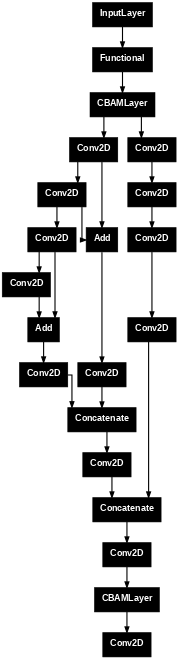

In [ ]:
from keras.utils import plot_model
plot_model(model,dpi=40)

In [ ]:
def crowd_counting_loss(y_true, y_pred, alpha, gamma):
    """
    Combined loss for crowd counting
    """
    # MSE component (for overall density estimation)
    mse_loss = tf.reduce_mean(tf.square(y_true - y_pred))

    # Focal loss component (for hard examples)
    abs_error = tf.abs(y_true - y_pred)
    focal_weight = tf.pow(abs_error + 1e-8, gamma)  # Add small epsilon
    focal_loss = tf.reduce_mean(focal_weight * tf.square(y_true - y_pred))

    # Combine both losses
    total_loss = (1 - alpha) * mse_loss + alpha * focal_loss

    return total_loss

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import MeanAbsoluteError

# Compile model with Adam optimizer and MSE loss + MAE metric
model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss=lambda y_true, y_pred: crowd_counting_loss(y_true, y_pred, alpha=0.7, gamma=4.0),
    metrics=[MeanAbsoluteError()]
)

# EarlyStopping on training loss (lower is better)
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=4,
    verbose=1,
    mode='min',
    restore_best_weights=True
)

# Reduce learning rate on plateau (training loss)
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=2,
    verbose=1,
    min_lr=1e-8
)

# Train the model using generators
history = model.fit(
    train_gen,
    validation_data=val_gen,
    steps_per_epoch=100,
    validation_steps=10,
    epochs=100,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 127s 956ms/step - loss: 4.6664e-04 - mean_absolute_error: 0.0187 - val_loss: 1.6172e-04 - val_mean_absolute_error: 0.0073 - learning_rate: 1.0000e-05
Epoch 2/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 141s 1s/step - loss: 1.1981e-04 - mean_absolute_error: 0.0073 - val_loss: 1.1749e-04 - val_mean_absolute_error: 0.0070 - learning_rate: 1.0000e-05
Epoch 3/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 92s 917ms/step - loss: 1.1262e-04 - mean_absolute_error: 0.0065 - val_loss: 1.3962e-04 - val_mean_absolute_error: 0.0066 - learning_rate: 1.0000e-05
Epoch 4/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 872ms/step - loss: 1.0730e-04 - mean_absolute_error: 0.0060
Epoch 4: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-06.
100/100 ━━━━━━━━━━━━━━━━━━━━ 142s 1s/step - loss: 1.0723e-04 - mean_absolute_error: 0.0060 - val_loss: 6.5596e-05 - val_mean_absolute_error: 0.0055 - learning_rate: 1.0000e-05
Epoch 5/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 142s 1s/step - loss: 1.0258e-04 - 

In [ ]:
# Save the model in HDF5 format
model.save('new_model_11.keras')

# Download the model file to your laptop
from google.colab import files
files.download('new_model_11.keras')

/usr/local/lib/python3.11/dist-packages/keras/src/saving/serialization_lib.py:390: UserWarning: The object being serialized includes a `lambda`. This is unsafe. In order to reload the object, you will have to pass `safe_mode=False` to the loading function. Please avoid using `lambda` in the future, and use named Python functions instead. This is the `lambda` being serialized:     loss=lambda y_true, y_pred: crowd_counting_loss(y_true, y_pred, alpha=0.6, gamma=4.0),

  return {key: serialize_keras_object(value) for key, value in obj.items()}


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import os
import scipy.io
import cv2
import numpy as np
import matplotlib.pyplot as plt

def load_ground_truth(mat_file):
    data = scipy.io.loadmat(mat_file)
    points = data['image_info'][0,0][0,0][0]
    return points

def preprocess_image_patch(patch):
    patch = patch / 255.0
    patch = np.expand_dims(patch, axis=0)
    return patch

def resize_image_and_gt(image, gt_points, target_size=(1024, 1024)):
    h_org, w_org, _ = image.shape
    image_resized = cv2.resize(image, target_size)
    x_ratio = target_size[0] / w_org
    y_ratio = target_size[1] / h_org
    gt_rescaled = np.array([[p[0]*x_ratio, p[1]*y_ratio] for p in gt_points])
    return image_resized, gt_rescaled

# Set paths
test_image_dir = '/content/drive/MyDrive/test/images'
test_gt_dir = '/content/drive/MyDrive/test/ground_truth'
test_files = os.listdir(test_image_dir)

# Evaluation
total_absolute_error = 0
total_samples = 0
patch_size = 512

In [ ]:
big_error = []
for file in test_files:
    image_path = os.path.join(test_image_dir, file)
    gt_path = os.path.join(test_gt_dir, "GT_" + file.replace(".jpg", ".mat"))

    # Load image and GT
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    points = load_ground_truth(gt_path)

    # Resize image and GT
    image_resized, gt_points_rescaled = resize_image_and_gt(image, points)

    predicted_total_count = 0
    gt_total_count = 0

    # Process 4 patches
    for i in range(2):  # row index
        for j in range(2):  # col index
            x_start = j * patch_size
            y_start = i * patch_size
            x_end = x_start + patch_size
            y_end = y_start + patch_size

            # Image patch
            image_patch = image_resized[y_start:y_end, x_start:x_end, :]
            image_patch_input = preprocess_image_patch(image_patch)

            # Prediction
            predicted_density = model.predict(image_patch_input)
            predicted_density = np.squeeze(predicted_density)
            predicted_patch_count = predicted_density.sum()
            predicted_total_count += predicted_patch_count

            # GT points in this patch
            gt_patch_points = []
            for pt in gt_points_rescaled:
                if x_start <= pt[0] < x_end and y_start <= pt[1] < y_end:
                    gt_patch_points.append([pt[0] - x_start, pt[1] - y_start])
            gt_patch_count = len(gt_patch_points)
            gt_total_count += gt_patch_count

    # Compute error
    error = abs(predicted_total_count - gt_total_count)
    total_absolute_error += error
    total_samples += 1

    big_error.append([file, predicted_total_count, gt_total_count, error])

    print(f"Image: {file}")
    print(f"Predicted Count: {predicted_total_count:.2f}")
    print(f"Ground Truth Count: {gt_total_count}")
    print(f"Absolute Error: {error:.2f}\n")

# Final MAE
mae = total_absolute_error / total_samples
print(f"Mean Absolute Error on test set: {mae:.2f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
Image: IMG_1.jpg
Predicted Count: 32.67
Ground Truth Count: 23
Absolute Error: 9.67

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
Image: IMG_278.jpg
Predicted Count: 82.41
Ground Truth Count: 57
Absolute Error: 25.41

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
Image: IMG_188.jpg
Predicted Count: 58.33
Ground Truth Count: 56
Absolute Error: 2.33

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
Image: IMG_264.jpg
Predicted Count: 47.42
Ground Truth Count: 36
Absolute Error: 11.42

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/

In [ ]:
sorted_big_error = sorted(big_error, key=lambda x: x[3], reverse=True)

for file, pred, gt, error in sorted_big_error:
    print(f"Image: {file}, Predicted: {pred:.2f}, Ground Truth: {gt}, Absolute Error: {error:.2f}")

Image: IMG_75.jpg, Predicted: 326.50, Ground Truth: 539, Absolute Error: 212.50
Image: IMG_80.jpg, Predicted: 303.26, Ground Truth: 470, Absolute Error: 166.74
Image: IMG_152.jpg, Predicted: 362.40, Ground Truth: 505, Absolute Error: 142.60
Image: IMG_12.jpg, Predicted: 371.01, Ground Truth: 513, Absolute Error: 141.99
Image: IMG_247.jpg, Predicted: 213.80, Ground Truth: 104, Absolute Error: 109.80
Image: IMG_219.jpg, Predicted: 352.11, Ground Truth: 450, Absolute Error: 97.89
Image: IMG_309.jpg, Predicted: 156.97, Ground Truth: 63, Absolute Error: 93.97
Image: IMG_223.jpg, Predicted: 230.05, Ground Truth: 144, Absolute Error: 86.05
Image: IMG_74.jpg, Predicted: 176.93, Ground Truth: 261, Absolute Error: 84.07
Image: IMG_316.jpg, Predicted: 348.02, Ground Truth: 429, Absolute Error: 80.98
Image: IMG_112.jpg, Predicted: 210.29, Ground Truth: 131, Absolute Error: 79.29
Image: IMG_100.jpg, Predicted: 83.50, Ground Truth: 157, Absolute Error: 73.50
Image: IMG_257.jpg, Predicted: 200.95, Gr

In [ ]:
import cv2
import numpy as np
import tensorflow as tf
from google.colab.patches import cv2_imshow
import time

# Load model (your head detection or classification model)
# model = tf.keras.models.load_model("head_detection_model.h5", compile=False)

# Input size assumptions
PATCH_SIZE = 512
TARGET_SHAPE = (1024, 1024)

video_path = '/content/drive/MyDrive/crowd_test_data/1.mp4'
output_path = '/content/drive/MyDrive/crowd_count_output.mp4'

In [ ]:
def preprocess_patch(patch):
    patch = patch / 255.0
    return np.expand_dims(patch, axis=0)

# Count heads from prediction
def count_heads(pred, threshold=0.5):
    heatmap = pred[0, :, :, 0]
    binary_map = (heatmap > threshold).astype(np.uint8)
    contours, _ = cv2.findContours(binary_map, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    return sum(1 for cnt in contours if cv2.contourArea(cnt) > 30)

# Helper: split resized frame into 4 non-overlapping 512x512 patches
def split_into_patches(image):
    patches = []
    for i in range(0, 1024, 512):
        for j in range(0, 1024, 512):
            patch = image[i:i+512, j:j+512]
            patches.append(patch)
    return patches

In [ ]:
# Video I/O
cap = cv2.VideoCapture(video_path)
fps = int(cap.get(cv2.CAP_PROP_FPS))
w_orig = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
h_orig = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

# Output video writer
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter(output_path, fourcc, fps, (w_orig, h_orig))

frame_num = 0

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    frame_num += 1
    resized = cv2.resize(frame, TARGET_SHAPE)

    patches = split_into_patches(resized)
    total_count = 0

    for patch in patches:
        inp = preprocess_patch(patch)
        pred = model.predict(inp, verbose=0)
        count = count_heads(pred) #####
        total_count += count

    # Overlay the total count on the original frame (not resized)
    cv2.putText(frame, f"frame: {frame_num}", (20, 40),
                cv2.FONT_HERSHEY_SIMPLEX, 1.0, (255, 255, 255), 2)
    cv2.putText(frame, f"crowd count: {total_count}", (20, 80),
                cv2.FONT_HERSHEY_SIMPLEX, 1.2, (0, 255, 0), 3)

    out.write(frame)

cap.release()
out.release()

print(" Video processing complete. Output saved at:", output_path)

KeyboardInterrupt: 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from google.colab import files
model = files.upload()

Saving new_model_10.keras to new_model_10.keras
